In [43]:
import nba_api
import pandas as pd
import sklearn
import os
import numpy as np
import requests
import time
import random
from sklearn.model_selection import KFold
import datetime as dt
import seaborn as sns
from nba_api.stats.static import players
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta
from nba_api.stats.library.parameters import SeasonAllNullable
from nba_api.stats.library.parameters import SeasonAll
from nba_api.stats.library.parameters import SeasonTypeNullable
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
from tqdm import tqdm
from scipy.stats import norm
from nba_api.stats import endpoints
from nba_api.stats.static import teams
from sklearn.ensemble import RandomForestClassifier
import ipynb
import importlib


## Also read in cleaned NBA data
NBAgamesC = pd.read_csv('/Users/nickbachelder/Buckets Model/NBAgamesC', index_col=0)
NBAgamesC['GAME_DATE_H'] = pd.to_datetime(NBAgamesC['GAME_DATE_H'])
nba_team = pd.read_csv('/Users/nickbachelder/Buckets Model/nba_team', index_col=0)
NBAgames = pd.read_csv('/Users/nickbachelder/Buckets Model/NBAgames', index_col=0)
NBAgames['GAME_DATE'] = pd.to_datetime(NBAgames['GAME_DATE'])
NBAgamesC['GAME_ID_H'] = NBAgamesC['GAME_ID_H'].astype(int)

In [45]:
## Get Starting ELOs from 2015 from fivethirtyeight. We will use this as starting point for elo tracking.

url = "https://raw.githubusercontent.com/fivethirtyeight/data/master/nba-elo/nbaallelo.csv"
five38rate = pd.read_csv(url, index_col=0)


five38rate= five38rate.replace({'NOH': 'NOP',
                               'NOK': 'NOP',
                               'NOH': 'NOP',
                               'NJN': 'BKN',
                               'SEA': 'OKC',
                               'VAN': 'MEM',
                               'KCK': 'SAC',
                               'SDC': 'LAC',
                               'WSB': 'WAS',
                               'PHO': 'PHX'}, regex=True)




games15 = five38rate[five38rate['year_id'] == 2000].sort_values('date_game')


In [46]:
## define function to get starting elos

def get_ELO_15(team_abb):
    games15team = games15[games15['team_id'] == team_abb]
    if games15team.empty:
        teamlltime = five38rate[five38rate['team_id'] == team_abb]
        rating = teamlltime.iloc[-1,:]['elo_n']
    else:
        rating = games15team.iloc[-1,:]['elo_n']
    return(rating)

In [47]:
## define function to track elo over time and create ongoing dataframe

## ELO Rating # FIX INTER_SEASON CHANGES
def get_ELO_track():
    AllSeasonGames = pd.DataFrame(NBAgamesC).iloc[::-1].reset_index(drop = 1) ## In correct order
    CurrSeason = AllSeasonGames.iloc[0,]['SEASON_ID_H']
    
    ELO_track = pd.DataFrame() ## Creating starting ELOs from the fivethirtyeight 1982 data
    for team in nba_team['abbreviation']:
        ELO_start = {'Team': team,
                     'ELO': get_ELO_15(team),
                     'Date': AllSeasonGames.iloc[0,]['GAME_DATE_H'],
                     'Season': CurrSeason}
        ELO_track = ELO_track.append(pd.DataFrame(ELO_start, index=[0]))
    date = AllSeasonGames.iloc[0,]['GAME_DATE_H']
    end_date = AllSeasonGames.iloc[-1,]['GAME_DATE_H']
    delta = dt.timedelta(days=1)
    seasonindex = 1
    ELO_track = ELO_track.reset_index(drop = 1)
    
    while date <= end_date:
        ThisDayGames = pd.DataFrame(AllSeasonGames[AllSeasonGames['GAME_DATE_H'] == date]).reset_index(drop = 1)
        if ThisDayGames.empty:
            date += delta
            continue
        if ThisDayGames[['SEASON_ID_H']].iloc[0,][0] != CurrSeason: 
            for team in np.array(nba_team['abbreviation']):
                old_ELO = ELO_track[ELO_track['Team'] == team][['ELO']].iloc[-1,:]
                new_ELO = (.75 * old_ELO) + (.25 * 1505)
                newELOadd = {'Team': team,
                             'ELO': new_ELO,
                             'Date': date - delta,
                             'Season': ThisDayGames[['SEASON_ID_H']].iloc[0,][0]
                             }
            CurrSeason = ThisDayGames[['SEASON_ID_H']].iloc[0,][0]
            print('New Season', 'Season', seasonindex, 'Complete', '. Start', CurrSeason)
            seasonindex+=1
        for index in range(len(ThisDayGames)):
            game = ThisDayGames.iloc[index,:]
            gamedate = game[['GAME_DATE_H']][0]
            gamescore_diff = abs(int(game['PTS_H'])-int(game['PTS_A']))
            
            team1_abb = game[['MATCHUP_H']][0][0:3]
            team2_abb = game[['MATCHUP_H']][0][-3:]
            team1 = nba_team.loc[nba_team['abbreviation'] == team1_abb]['full_name'].values[0]
            team2 = nba_team.loc[nba_team['abbreviation'] == team2_abb]['full_name'].values[0]
            team1id = nba_team.loc[nba_team['abbreviation'] == team1_abb]['id'].values[0]
            team2id = nba_team.loc[nba_team['abbreviation'] == team2_abb]['id'].values[0]
            
            
            t1W = game['WL_H'] 
            
            t1_ELO = ELO_track[ELO_track['Team'] == team1_abb].iloc[-1,:][['ELO']]
            t2_ELO = ELO_track[ELO_track['Team'] == team2_abb].iloc[-1,:][['ELO']]
    
            
            ## ELO FORMULA
            if game['WL_H'] == 1:
                S_teamT1 = 1
                S_teamT2 = 0
            else:
                S_teamT1 = 0
                S_teamT2 = 1
            
            if S_teamT1 == 1:
                ELO_diff = (t1_ELO+100) - t2_ELO ## 100 extra points for home team
            else:
                ELO_diff = t2_ELO - (t1_ELO+100)
                
            E_teamT1 = 1/(1 + 10**((t2_ELO-(t1_ELO+100))/400)) ## 100 extra points for home team
            E_teamT2 = 1/(1 + 10**(((t1_ELO+100)-t2_ELO)/400))
    
            kt1 = 20*( (gamescore_diff+3)**0.8 / (7.5 + 0.006*ELO_diff))
            kt2 = 20*( (gamescore_diff+3)**0.8 / (7.5 + 0.006*ELO_diff))
            # Compute new ELOs
            t1_ELO_new = kt1*(S_teamT1 - E_teamT1) + t1_ELO
            t2_ELO_new = kt2*(S_teamT2 - E_teamT2) + t2_ELO
            
            ELOt1_append = {'Team': team1_abb,
             'ELO': t1_ELO_new,
             'Date': gamedate,
                           'Season': CurrSeason}
            ELOt2_append = {'Team': team2_abb,
             'ELO': t2_ELO_new,
             'Date': gamedate,
                           'Season': CurrSeason}
            addtoELO = pd.concat([pd.DataFrame(ELOt1_append), pd.DataFrame(ELOt2_append)], axis = 0)
            ELO_track = ELO_track.append(addtoELO).reset_index(drop = 1)
        date += delta
    return(ELO_track)

In [48]:
# Track ELOS

ELO_track = get_ELO_track() 

New Season Season 1 Complete . Start 2001
New Season Season 2 Complete . Start 2002
New Season Season 3 Complete . Start 2003
New Season Season 4 Complete . Start 2004
New Season Season 5 Complete . Start 2005
New Season Season 6 Complete . Start 2006
New Season Season 7 Complete . Start 2007
New Season Season 8 Complete . Start 2008
New Season Season 9 Complete . Start 2009
New Season Season 10 Complete . Start 2010
New Season Season 11 Complete . Start 2011
New Season Season 12 Complete . Start 2012
New Season Season 13 Complete . Start 2013
New Season Season 14 Complete . Start 2014
New Season Season 15 Complete . Start 2015
New Season Season 16 Complete . Start 2016
New Season Season 17 Complete . Start 2017
New Season Season 18 Complete . Start 2018
New Season Season 19 Complete . Start 2019
New Season Season 20 Complete . Start 2020


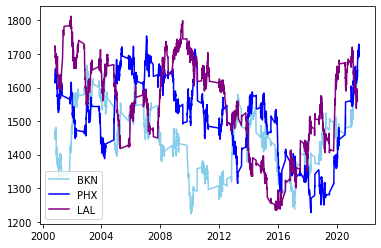

In [54]:
### Lets look at the tracked ELO for three teams

Track_GSW = ELO_track[(ELO_track['Team'] == 'LAL')]
Track_BOS = ELO_track[(ELO_track['Team'] == 'PHX')]
Track_CHI = ELO_track[(ELO_track['Team'] == 'BKN')]

# multiple line plots
plt.plot( 'Date', 'ELO', data= Track_CHI, color='skyblue', label = 'BKN')
plt.plot( 'Date', 'ELO', data= Track_BOS, color='blue', label = 'PHX')
plt.plot( 'Date', 'ELO', data= Track_GSW, color='purple', label = 'LAL')


plt.legend()
# show graph
plt.show()

In [50]:
# Define function that gets a teams ELO on a certain date after 2015

def get_pre_elo(team_abb, gamedate, NBAgamesC, ELO_track):
    import warnings
    warnings.simplefilter("ignore", UserWarning)
    
    team = NBAgamesC[NBAgamesC['MATCHUP_H'].str.contains(team_abb) | NBAgamesC['MATCHUP_A'].str.contains(team_abb)]
    teambeforedate = team[team['GAME_DATE_H'] < gamedate]
    priorgamedate = pd.DataFrame(teambeforedate['GAME_DATE_H']).iloc[0,:][0]
    pre_elo = ELO_track[ELO_track['Date'] ==  priorgamedate][ELO_track['Team'] ==  team_abb]['ELO']
    return(int(pre_elo))

# Check random ELO

get_pre_elo('LAL', '2021-04-01', NBAgamesC = NBAgamesC, ELO_track = ELO_track)

1581

In [51]:
ELO_track

,Team,ELO,Date,Season
0,ATL,1325.69,2000-10-31,2000
1,BOS,1431.22,2000-10-31,2000
2,CLE,1413.41,2000-10-31,2000
3,NOP,1526.57,2000-10-31,2000
4,CHI,1271.95,2000-10-31,2000
...,...,...,...,...
55503,PHX,1709.46,2021-07-14,2020
55504,PHX,1700.14,2021-07-17,2020
55505,MIL,1698.8,2021-07-17,2020
55506,MIL,1704.44,2021-07-20,2020


In [52]:
pd.DataFrame.to_csv(ELO_track, '/Users/nickbachelder/Buckets Model/ELO_track')

In [53]:
ELO_TRACK = pd.read_csv('/Users/nickbachelder/Buckets Model/ELO_track', index_col=0)
ELO_TRACK['Date'] = pd.to_datetime(ELO_TRACK['Date'])

get_pre_elo('MIL', '2021-09-08', NBAgamesC = NBAgamesC, ELO_track = ELO_TRACK)

1604

In [57]:
get_pre_elo('OKC', '2021-09-08', NBAgamesC = NBAgamesC, ELO_track = ELO_TRACK)

1239